In [ ]:
# !pip install pytorch-lightning

In [ ]:
import tqdm
import torch
from torch import nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from torchvision import transforms, datasets

In [2]:
max_epochs = 10
val_pct = 0.3
batch_size = 128
embedding_size = 64
lr = 1e-3
weight_decay = 1e-6

In [3]:
class MnistDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, val_pct, batch_size):
        super().__init__()
        self.data_dir = data_dir
        self.T = transforms.ToTensor()
        self.val_pct = val_pct
        self.batch_size = batch_size

    def prepare_data(self):
        datasets.MNIST(self.data_dir, train=True, download=True)
        datasets.MNIST(self.data_dir, train=True, download=True)

    def setup(self, stage=None):
        data = datasets.MNIST(self.data_dir, train=True, transform=self.T)
        val_len = int(val_pct * len(data))
        self.train_data, self.val_data = random_split(data, [len(data) - val_len, val_len])
        self.test_data = datasets.MNIST(self.data_dir, train=False, transform=self.T)

    def get_dataloader(self, data):
        return DataLoader(data, batch_size=self.batch_size, num_workers=2, pin_memory=True)

    def train_dataloader(self):
        return self.get_dataloader(self.train_data)

    def val_dataloader(self):
        return self.get_dataloader(self.val_data)

    def test_dataloader(self):
        return self.get_dataloader(self.test_data)

In [5]:
class Model(pl.LightningModule):
    def __init__(self, embedding_size, lr, weight_decay):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True), 
            nn.Linear(256, 128), 
            nn.ReLU(True), 
            nn.Linear(128, embedding_size)
        )

        self.decoder = nn.Sequential(
            nn.Linear(embedding_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True), 
            nn.Linear(512, 28*28), 
            nn.Sigmoid()
        )
        self.lr = lr
        self.weight_decay = weight_decay
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

    def shared_step(self, batch, split):
        x, _ = batch
        x = x.view(x.shape[0], -1)
        preds = self(x)
        loss = self.loss_fn(preds, x)
        self.log(f'{split}_loss', loss, on_epoch=True, prog_bar=True)
        if split == 'train':
            return loss

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch, 'train')
        return loss

    def validation_step(self, batch, batch_idx):
        self.shared_step(batch, 'val')

    def test_step(self, batch, batch_idx):
        self.shared_step(batch, 'test')

In [6]:
class PrintMetrics(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        final_str = f"epoch: {trainer.current_epoch} | "
        for k, v in trainer.callback_metrics.items():
            if "train" in k and "epoch" in k:
                final_str += f"{k.replace('_epoch', '')}: {v.item():.4f} | "
            elif "val" in k:
                final_str += f"{k}: {v.item():.4f} | "
        print(final_str[:-3])

In [7]:
mnist_dm = MnistDataModule('data/', val_pct, batch_size)
model = Model(embedding_size, lr, weight_decay)

In [8]:
trainer = pl.Trainer(max_epochs=max_epochs, gpus=1, callbacks=[PrintMetrics()])
trainer.fit(model, mnist_dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 574 K 
1 | decoder | Sequential | 575 K 
2 | loss_fn | MSELoss    | 0     
---------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     To

epoch: 0 | val_loss: 0.2315 | train_loss: 0.0626


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  "Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2"


epoch: 1 | val_loss: 0.0460 | train_loss: 0.0377


epoch: 2 | val_loss: 0.0327 | train_loss: 0.0297


epoch: 3 | val_loss: 0.0278 | train_loss: 0.0263


epoch: 4 | val_loss: 0.0255 | train_loss: 0.0240


epoch: 5 | val_loss: 0.0236 | train_loss: 0.0225


epoch: 6 | val_loss: 0.0227 | train_loss: 0.0215


epoch: 7 | val_loss: 0.0216 | train_loss: 0.0204


epoch: 8 | val_loss: 0.0204 | train_loss: 0.0194


epoch: 9 | val_loss: 0.0197 | train_loss: 0.0184


In [14]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.01884525828063488}
--------------------------------------------------------------------------------


[{'test_loss': 0.01884525828063488}]

In [15]:
@torch.no_grad()
def plot_examples(loader):
    model.eval()
    x, _ = next(iter(loader))
    x = x.view(x.shape[0], -1).to(model.device)
    x_hat = model(x)
    x = x.view(x.shape[0], 28, 28)
    x_hat = x_hat.view(x.shape[0], 28, 28)
    rows = torch.cat([x, x_hat], axis=1)
    imgs = torch.cat([rows[i] for i in range(42, 52)], axis=1).cpu().detach()
    plt.figure(figsize=(20, 5))
    plt.imshow(imgs, cmap='gray')
    plt.axis('off')

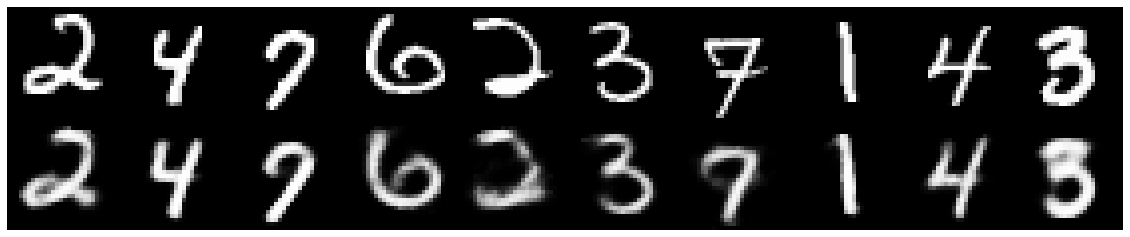

In [16]:
plot_examples(mnist_dm.train_dataloader())

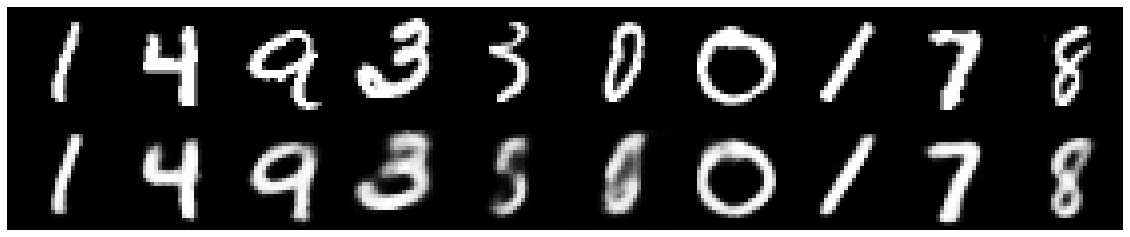

In [17]:
plot_examples(mnist_dm.val_dataloader())

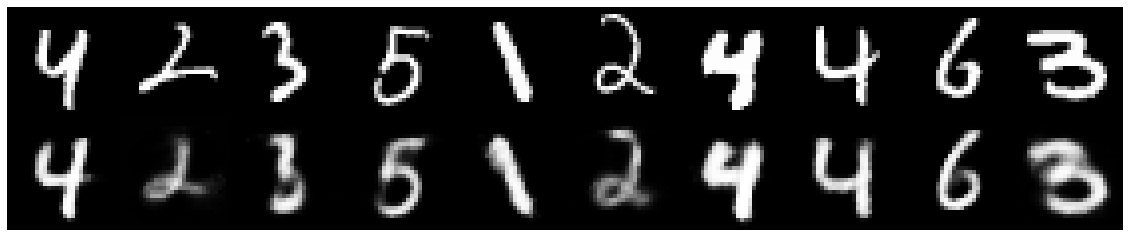

In [19]:
plot_examples(mnist_dm.test_dataloader())